In [1]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 67.2 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Sat Feb  4 06:05:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
data_train = pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2016/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2016/test.csv')

In [5]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors recommend between 2 and 4).
epochs = 4

# same as e_bert_pytorch
batch_size = 20

# Pad or truncate text sequences to a specific length
# same as e_bert_pytorch
max_length = 200

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# From HuggingFaces
model_name_or_path = 'gpt2'

# String labels to number ids.
labels_ids = {'Negative': 0, 'Neutral': 1, 'Positive' : 2}

# How many labels are we using in training.
n_labels = len(labels_ids)

In [6]:
class EuCommentsDataset(Dataset):
  r"""PyTorch Dataset helper class for loading data.
  """
  def __init__(self, texts, labels, use_tokenizer):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer

    self.n_examples = len(self.labels)
    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}

In [7]:
class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton task.    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    Arguments:
      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.
      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.
      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences.
    """
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder
        return

    def __call__(self, sequences):
        r"""
        This function allows the class object to be used as a function call.
        Arguments:
          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """
        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})
        return inputs

In [8]:
def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.
  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  Arguments:
      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.
      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.
      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.
      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """
  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [9]:
def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.
  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  Arguments:
    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.
    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.
  Returns:   

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """
  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## Load Model and Tokenizer (Differs from BERT)

>GPT2, son token'ı prediction için kullandığından, BERT'ten farklı olarak, padding sola doğru yapılmalıdır. Burada **tokenizer.padding_side = "left"** ile ilgili işlem yapılır.<br>
Ardından HuggingFaces kütüphanesinden GPT2 tokenizer ve GPT2 classification modeli çağırılır.


In [10]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


Loading tokenizer...


Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [11]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = EuCommentsDataset(data_train.tweet.to_numpy(), data_train.Analysis.to_numpy(), use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  EuCommentsDataset(data_test.tweet.to_numpy(), data_test.Analysis.to_numpy(), use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 75000 examples!
Created `train_dataloader` with 3750 batches!

Dealing with Validation...
Created `valid_dataset` with 7736 examples!
Created `eval_dataloader` with 387 batches!


In [12]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/3750 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/387 [00:00<?, ?it/s]

  train_loss: 0.23036 - val_loss: 0.90221 - train_acc: 0.92329 - valid_acc: 0.77921


Training on batches...


  0%|          | 0/3750 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/387 [00:00<?, ?it/s]

  train_loss: 0.15126 - val_loss: 0.58151 - train_acc: 0.95409 - valid_acc: 0.82239


Training on batches...


  0%|          | 0/3750 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/387 [00:00<?, ?it/s]

  train_loss: 0.11419 - val_loss: 1.04337 - train_acc: 0.97119 - valid_acc: 0.85471


Training on batches...


  0%|          | 0/3750 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/387 [00:00<?, ?it/s]

  train_loss: 0.08392 - val_loss: 0.62333 - train_acc: 0.97747 - valid_acc: 0.85096



/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


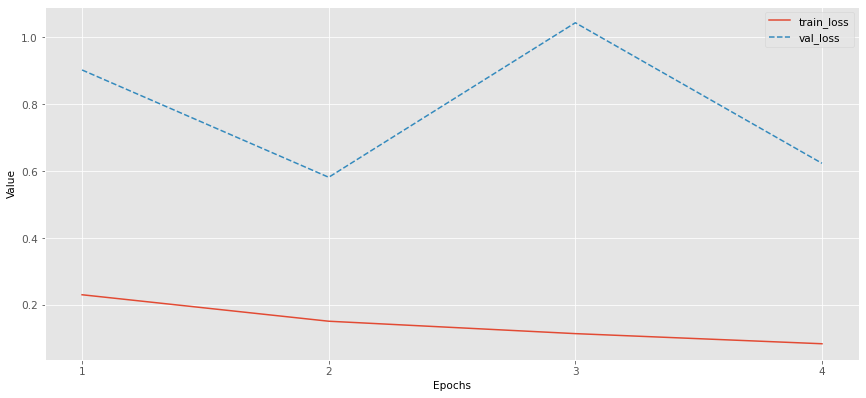

/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


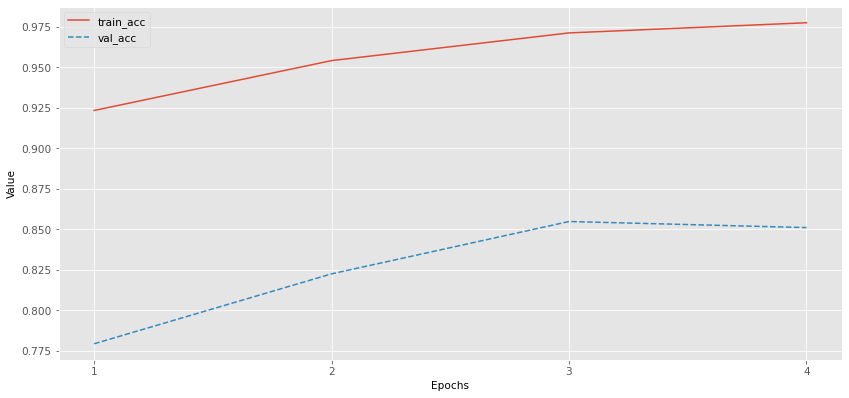

In [19]:
# Plot loss curves.
#!pip install matplotlib==3.1.3
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
 

In [14]:
# Get predictions for val. data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

  0%|          | 0/387 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Negative       0.91      0.74      0.82       757
     Neutral       0.86      0.89      0.87      4099
    Positive       0.82      0.83      0.83      2880

    accuracy                           0.85      7736
   macro avg       0.87      0.82      0.84      7736
weighted avg       0.85      0.85      0.85      7736

